In [1]:
from scipy import io
from pathlib import Path

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import optax

from collections import defaultdict
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from dynamax.hidden_markov_model import CircHMMsT
from dynamax.utils.plotting import gradient_cmap

from functools import partial
from jax import vmap

2024-10-09 14:47:30.963561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 14:47:30.972486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 14:47:30.975127: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 14:47:31.508579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
num_train_batches = 10000
num_test_batches = 500
num_timesteps = 20

key = jr.PRNGKey(1)

# Make an HMM and sample data and true underlying states
true_num_states = 5
input_dim = 2
emission_dim = 1
hmm = CircHMMsT(true_num_states, input_dim, emission_dim, transition_matrix_concentration=2, transition_matrix_stickiness= 10)

# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states

# transition_weights = 1 * jr.normal(key, (true_num_states, true_num_states, input_dim))
# transition_matrix = 0.1 * jr.normal(key, (true_num_states, true_num_states))

emission_weights = 0.1 * jr.normal(key, (true_num_states, emission_dim, input_dim))
emission_covs = jnp.tile(jnp.eye(emission_dim), (true_num_states, 1, 1)) * 50


In [3]:
# distribute -pi to pi evenly in state range
offset = 0
state_range = (jnp.linspace(0.1, 1.6 * jnp.pi, true_num_states) + offset) % ( 2* jnp.pi) - jnp.pi
# emission_weights
emission_weights_mod = emission_weights.at[:, 0, 1].set(state_range)
emission_weights_mod
state_range

Array([-3.0415928 , -1.8099556 , -0.5783186 ,  0.65331864,  1.8849556 ],      dtype=float32)

In [4]:
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                # transition_matrix=transition_mat_mod,
                                emission_weights=emission_weights_mod,
                                emission_covariances=emission_covs)

In [5]:
true_params.transitions.transition_matrix

Array([[0.66746056, 0.0275996 , 0.10142594, 0.07511953, 0.1283943 ],
       [0.03295066, 0.5235361 , 0.09683266, 0.23823701, 0.10844356],
       [0.05178186, 0.24348849, 0.4456512 , 0.1862447 , 0.07283381],
       [0.09797047, 0.04589259, 0.05409027, 0.68762887, 0.11441779],
       [0.02370666, 0.1691034 , 0.3427932 , 0.08072241, 0.38367426]],      dtype=float32)

In [6]:
# choose from 0 to 1 randomly num_timesteps times
first_input = jr.uniform(key, (num_train_batches, num_timesteps,1))
intercept = jnp.ones((num_train_batches, num_timesteps, 1))

inputs_batch_train = jnp.concatenate([first_input, intercept], axis=-1)


# do for the test batch
first_input = jr.uniform(key, (num_test_batches, num_timesteps,1))
intercept = jnp.ones((num_test_batches, num_timesteps, 1))

inputs_batch_test = jnp.concatenate([first_input, intercept], axis=-1)

inputs_batch_train.shape, inputs_batch_test.shape

((10000, 20, 2), (500, 20, 2))

In [7]:
# # Sample train, validation, and test data
# train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
# f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps, inputs=jnp.ones((num_timesteps, input_dim))))
# train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
# test_true_states,  test_emissions  = f(jr.split(test_key, num_test_batches))

In [8]:
# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)

# Split keys for each batch
train_keys = jr.split(train_key, num_train_batches)
test_keys = jr.split(test_key, num_test_batches)

# Define a function that samples given an input and key
def sample_fn(key, inputs):
    return hmm.sample(true_params, num_timesteps=num_timesteps, inputs=inputs, key=key)

# Vectorize the sampling over batches using vmap
train_true_states, train_emissions = vmap(sample_fn)(train_keys, inputs_batch_train)
test_true_states, test_emissions = vmap(sample_fn)(test_keys, inputs_batch_test)

In [9]:
train_emissions.shape, test_emissions.shape, train_true_states.shape, test_true_states.shape

((10000, 20, 1, 1), (500, 20, 1, 1), (10000, 20), (500, 20))

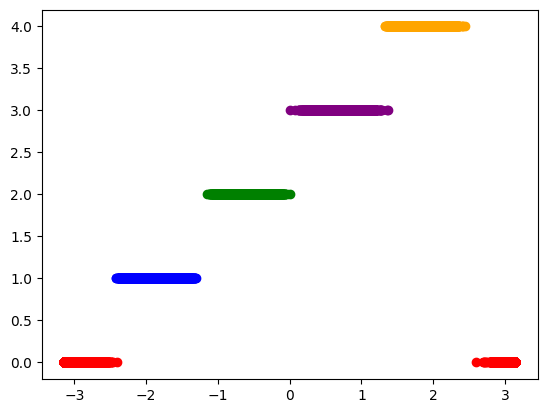

In [10]:
# visualize train data
# train_emissions.reshape(10,100)[0]

emm = train_emissions.reshape(-1)
tr = train_true_states.reshape(-1)

# emissions are radians, so plot them on the number line and color by state
fig, ax = plt.subplots()
for i in range(5):
    ax.scatter(emm[tr==i], tr[tr==i], color=["red", "blue", "green", "purple", "orange"][i])
plt.show()


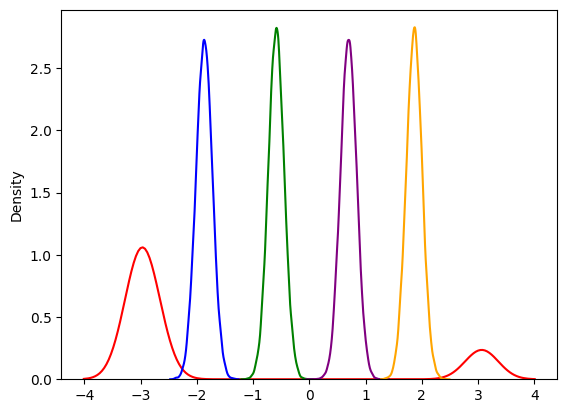

In [11]:
# using the tr as labels, plot the distribution of emm for each state
fig, ax = plt.subplots()
for i in range(5):
    sns.kdeplot(emm[tr==i], color=["red", "blue", "green", "purple", "orange"][i], ax=ax)
plt.show()


In [14]:
# only save the emissions and inputs

# Save the data
data = {
    "emissions": train_emissions,
    "inputs": inputs_batch_train,
}

# with open("data_emm_input.pkl", "wb") as f:
#     pkl.dump(data, f)

In [13]:
# np.savetxt("emissions.csv", train_emissions.reshape(10000, 20), delimiter=",")
# np.savetxt("inputs.csv", inputs_batch_train.reshape(10000, 20, 2), delimiter=",")


In [29]:
# store the train and test data
data = {"train_emissions": train_emissions, "test_emissions": test_emissions,
        "train_true_states": train_true_states, "test_true_states": test_true_states,
        "inputs_batch_train": inputs_batch_train, "inputs_batch_test": inputs_batch_test,
        "true_params": true_params}

# with open("ICLR_synth_data_1.pkl", "wb") as f:
#     pkl.dump(data, f)


In [31]:
train_emissions.shape, inputs_batch_train.shape

((10000, 20, 1, 1), (10000, 20, 2))

In [13]:
train_emissions.shape, inputs_batch_train.shape

((1000, 20, 1, 1), (1000, 20, 2))

In [14]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
test_hmm = CircHMMsT(5, input_dim, emission_dim, transition_matrix_concentration=2, transition_matrix_stickiness= 10)
params, props = test_hmm.initialize(key=key)
params, lps = test_hmm.fit_sgd( params = params, 
                                props = props, 
                                emissions = train_emissions.reshape(num_train_batches,num_timesteps,1), 
                                inputs = inputs_batch_train, 
                                num_epochs = 5000, 
                                optimizer = optax.adam(1e-3), 
                                shuffle = False,
                                batch_size = 8)

In [15]:
lps

Array([1.740142  , 1.7204986 , 1.6944934 , ..., 0.68913525, 0.68913525,
       0.68913525], dtype=float32)

In [16]:
train_true_states.shape

(1000, 20)

In [ ]:
# make test hmm predict the most linekly states for the train_emissions
predicted_train_states = []
for i in range(num_train_batches): predicted_train_states.append(test_hmm.most_likely_states(params, train_emissions.reshape(num_train_batches,num_timesteps,1)[i], inputs_batch_train[i]))
predicted_train_states = np.array(predicted_train_states)

In [75]:
inputs_batch_train.shape, train_emissions.shape

((80, 20, 2), (80, 20, 1, 1))

In [76]:
train_true_states

Array([[4, 3, 3, ..., 3, 3, 3],
       [2, 2, 4, ..., 0, 0, 0],
       [1, 3, 4, ..., 1, 3, 3],
       ...,
       [3, 3, 3, ..., 4, 2, 2],
       [2, 3, 1, ..., 3, 4, 4],
       [4, 2, 2, ..., 1, 0, 0]], dtype=int32)

In [77]:
predicted_train_states

array([[1, 2, 2, ..., 2, 2, 2],
       [3, 3, 1, ..., 0, 0, 0],
       [4, 2, 1, ..., 4, 2, 2],
       ...,
       [2, 2, 2, ..., 1, 3, 3],
       [3, 2, 4, ..., 2, 1, 1],
       [1, 3, 3, ..., 4, 0, 0]], dtype=int32)

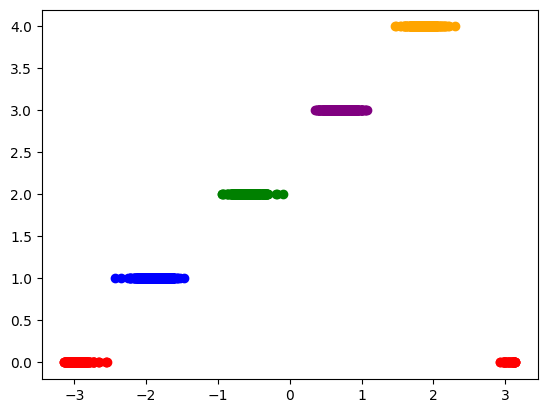

In [78]:
# train_emissions.reshape(10,100)[0]

# to visualize:
emm = train_emissions
tr = train_true_states

# emissions are radians, so plot them on the number line and color by state
fig, ax = plt.subplots()
for i in range(5):
    ax.scatter(emm[tr==i], tr[tr==i], color=["red", "blue", "green", "purple", "orange"][i])
plt.show()


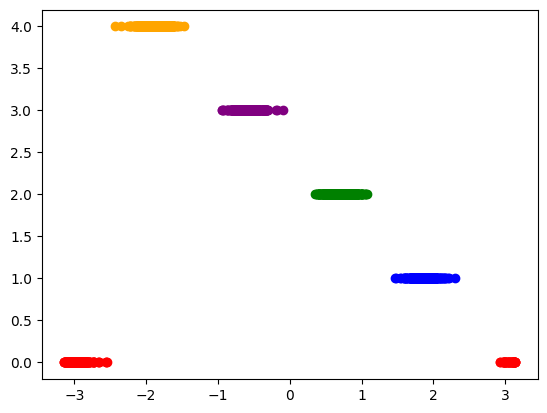

In [79]:
# train_emissions.reshape(10,100)[0]

# to visualize:
emm = train_emissions
tr = predicted_train_states

# emissions are radians, so plot them on the number line and color by state
fig, ax = plt.subplots()
for i in range(5):
    ax.scatter(emm[tr==i], tr[tr==i], color=["red", "blue", "green", "purple", "orange"][i])
plt.show()


In [80]:
params.emissions

ParamsCircEmissions(weights=Array([[[ 0.19260743, -3.1047559 ]],

       [[-0.04938317,  1.8911779 ]],

       [[ 0.03216312,  0.69942147]],

       [[-0.11463001, -0.5224305 ]],

       [[-0.20644675, -1.7489129 ]]], dtype=float32), covs=Array([[[44.545734]],

       [[45.394783]],

       [[48.569923]],

       [[55.7358  ]],

       [[48.87314 ]]], dtype=float32))

In [83]:
true_params.transitions.transition_matrix

Array([[0.66746056, 0.0275996 , 0.10142594, 0.07511953, 0.1283943 ],
       [0.03295066, 0.5235361 , 0.09683266, 0.23823701, 0.10844356],
       [0.05178186, 0.24348849, 0.4456512 , 0.1862447 , 0.07283381],
       [0.09797047, 0.04589259, 0.05409027, 0.68762887, 0.11441779],
       [0.02370666, 0.1691034 , 0.3427932 , 0.08072241, 0.38367426]],      dtype=float32)

In [84]:
params.transitions.transition_matrix

Array([[0.7161326 , 0.00645154, 0.00645153, 0.19999686, 0.07096743],
       [0.05116211, 0.283721  , 0.14418751, 0.42325413, 0.09767529],
       [0.06666505, 0.16422375, 0.6683002 , 0.08292487, 0.01788606],
       [0.03728827, 0.03728816, 0.27457836, 0.34237063, 0.30847454],
       [0.00317514, 0.03492052, 0.4158739 , 0.00317459, 0.54285586]],      dtype=float32)

In [ ]:
def cross_validate_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_sgd(params, 
                                              props, 
                                              y_train, 
                                              inputs=jnp.ones_like(y_train),
                                              num_epochs=num_iters)
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_emissions)
    return val_lls.mean(), val_lls

In [5]:
# Split it 80:20 for training and testing

train_idx = int(0.8 * len(design_matrix))

train_design = design_matrix[:train_idx]
train_obs = observation[:train_idx]

test_design = design_matrix[train_idx:]
test_obs = observation[train_idx:]

In [6]:
# convert to jax arrays
train_emissions = jnp.array(train_obs)
train_inputs = jnp.array(train_design)

In [7]:
# A training cache to store all the models and their parameters
training_cache = defaultdict(dict)

# DS to store the models organized
class Model_Store:
    n_states: int
    fit_model: None
    fit_params: None
    lps: None

In [8]:
def train_hmms(model_class, num_states, emission_dim, input_dim, train_emissions, train_inputs):
    
    model = model_class(num_states, input_dim, emission_dim)
    parameters, properties = model.initialize(key=jr.PRNGKey(1))

    # Fit with SGD
    fit_params, lps = model.fit_sgd(params = parameters, 
                                    props = properties, 
                                    emissions = train_emissions, 
                                    inputs = train_inputs, 
                                    num_epochs = 5000, 
                                    optimizer = optax.adam(1e-4), 
                                    shuffle = False, 
                                    batch_size = 32)
    
    return model, fit_params, lps

In [9]:
min_state, max_state = 2, 4
emission_dim, input_dim = 1, 5

for model_class in [CircHMM]:

    for num_states in range(min_state, max_state+1):
        print(f'Training: {model_class.__name__} - {num_states} states')

        model, fit_params, lps = train_hmms(model_class, num_states, emission_dim, input_dim, train_emissions, train_inputs)

        print(f"{lps[:10]}")

        t_store = Model_Store()
        t_store.n_states = num_states
        t_store.fit_model = model
        t_store.fit_params = fit_params
        t_store.lps = lps

        training_cache[model_class.__name__][num_states] = t_store


Training: CircHMM - 2 states
[2.0279927 2.0236886 2.0193982 2.0151236 2.0108643 2.0066216 2.0023966
 1.9981881 1.993997  1.9898232]
Training: CircHMM - 3 states
[2.0386946 2.0343192 2.029957  2.0256097 2.0212777 2.0169616 2.012662
 2.0083787 2.0041122 1.9998624]
Training: CircHMM - 4 states
[2.0404584 2.0360305 2.031616  2.027217  2.022834  2.0184677 2.014118
 2.009786  2.005471  2.0011735]


<Axes: >

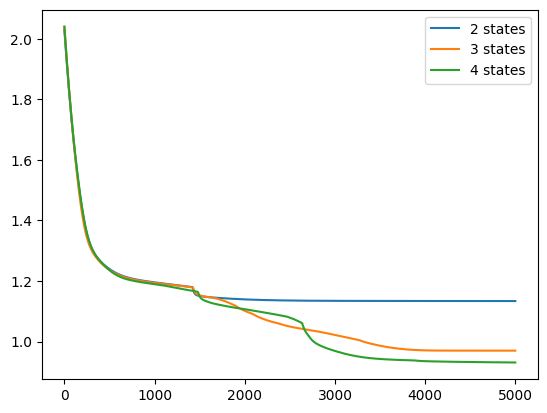

In [17]:
sns.lineplot(training_cache["CircHMM"][2].lps, label="2 states")
sns.lineplot(training_cache["CircHMM"][3].lps, label="3 states")
sns.lineplot(training_cache["CircHMM"][4].lps, label="4 states")

In [18]:
training_cache

Array([2.0404584, 2.0360305, 2.031616 , ..., 0.9309583, 0.9309559,
       0.9309536], dtype=float32)

In [19]:
training_cache["CircHMM"][4]

In [23]:
training_cache["CircHMM"][4].fit_params.transitions.transition_weights[0]

Array([[-0.23085745,  0.37730235,  0.28121665,  0.97430235,  1.4713405 ],
       [-0.7254634 ,  0.72348994, -0.45906   , -0.7803172 , -0.57019705],
       [-1.577803  , -1.6051687 , -1.6427596 , -1.6031122 , -1.6805452 ],
       [ 0.65423036, -1.2755809 ,  0.24850003, -0.21454309, -1.2671362 ]],      dtype=float32)

In [26]:
training_cache["CircHMM"][4].fit_params.emissions.weights

Array([[[ 2.83266187e-01,  1.07381800e-02, -6.40832484e-02,
          4.37593684e-02,  1.10763276e+00]],

       [[ 1.17694043e-01, -8.89237896e-02, -6.21083975e-02,
         -2.06562668e-01,  1.74767315e+00]],

       [[ 1.09972075e-01,  2.89706793e-02,  2.14026291e-02,
          1.42162833e-02,  6.28260374e-01]],

       [[ 3.66456471e-02,  2.39577387e-02,  8.37263884e-04,
          1.31549640e-02,  2.25558829e+00]]], dtype=float32)

In [27]:
training_cache["CircHMM"][4].fit_params.emissions.covs

Array([[[ 4.9348955]],

       [[ 1.9043467]],

       [[ 5.4074445]],

       [[40.73532  ]]], dtype=float32)

In [36]:
training_cache["CircHMM"][4].fit_model.emission_component.distribution(training_cache["CircHMM"][4].fit_params.emissions, 2)

TypeError: unsupported operand type(s) for @: 'ArrayImpl' and 'NoneType'